In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import os

## Prepare data

In [6]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [23]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=3)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after remo

In [58]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()

In [26]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

## Models

In [89]:
model = keras.Sequential([
    keras.layers.Dense(5, input_shape=(8,)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1)
])
optimizer = tf.train.AdamOptimizer(0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 5)                 45        
_________________________________________________________________
batch_normalization_13 (Batc (None, 5)                 20        
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 6         
Total params: 71
Trainable params: 61
Non-trainable params: 10
_________________________________________________________________


In [91]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [92]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=[X_val, y_val], callbacks=[early_stop])

Train on 825 samples, validate on 102 samples
Epoch 1/1000
825/825 [==============================] - 1s 1ms/step - loss: 1571.7807 - mean_absolute_error: 36.0778 - val_loss: 1636.6343 - val_mean_absolute_error: 37.0750
Epoch 2/1000
825/825 [==============================] - 0s 76us/step - loss: 1560.9965 - mean_absolute_error: 35.9479 - val_loss: 1622.3651 - val_mean_absolute_error: 36.8963
Epoch 3/1000
825/825 [==============================] - 0s 67us/step - loss: 1551.1403 - mean_absolute_error: 35.8238 - val_loss: 1609.3930 - val_mean_absolute_error: 36.7354
Epoch 4/1000
825/825 [==============================] - 0s 83us/step - loss: 1539.7187 - mean_absolute_error: 35.6894 - val_loss: 1597.2140 - val_mean_absolute_error: 36.5860
Epoch 5/1000
825/825 [==============================] - 0s 76us/step - loss: 1530.1345 - mean_absolute_error: 35.5680 - val_loss: 1585.2203 - val_mean_absolute_error: 36.4403
Epoch 6/1000
825/825 [==============================] - 0s 80us/step - loss: 151

825/825 [==============================] - 0s 87us/step - loss: 752.9938 - mean_absolute_error: 24.8037 - val_loss: 747.3938 - val_mean_absolute_error: 24.9074
Epoch 48/1000
825/825 [==============================] - 0s 92us/step - loss: 729.6645 - mean_absolute_error: 24.3974 - val_loss: 723.8085 - val_mean_absolute_error: 24.4682
Epoch 49/1000
825/825 [==============================] - 0s 100us/step - loss: 703.6979 - mean_absolute_error: 23.9307 - val_loss: 699.1436 - val_mean_absolute_error: 24.0043
Epoch 50/1000
825/825 [==============================] - 0s 100us/step - loss: 685.8232 - mean_absolute_error: 23.5009 - val_loss: 670.8823 - val_mean_absolute_error: 23.4584
Epoch 51/1000
825/825 [==============================] - 0s 99us/step - loss: 660.2383 - mean_absolute_error: 23.0508 - val_loss: 645.5938 - val_mean_absolute_error: 22.9756
Epoch 52/1000
825/825 [==============================] - 0s 96us/step - loss: 636.7723 - mean_absolute_error: 22.5959 - val_loss: 622.1311 - v

825/825 [==============================] - 0s 86us/step - loss: 145.6329 - mean_absolute_error: 9.8069 - val_loss: 135.1251 - val_mean_absolute_error: 9.7292
Epoch 95/1000
825/825 [==============================] - 0s 87us/step - loss: 140.1972 - mean_absolute_error: 9.6590 - val_loss: 133.1847 - val_mean_absolute_error: 9.6672
Epoch 96/1000
825/825 [==============================] - 0s 79us/step - loss: 133.5548 - mean_absolute_error: 9.5016 - val_loss: 131.6540 - val_mean_absolute_error: 9.5977
Epoch 97/1000
825/825 [==============================] - 0s 81us/step - loss: 132.0105 - mean_absolute_error: 9.3458 - val_loss: 130.1817 - val_mean_absolute_error: 9.5259
Epoch 98/1000
825/825 [==============================] - 0s 100us/step - loss: 136.7046 - mean_absolute_error: 9.4785 - val_loss: 130.2768 - val_mean_absolute_error: 9.5226
Epoch 99/1000
825/825 [==============================] - 0s 99us/step - loss: 132.9205 - mean_absolute_error: 9.3834 - val_loss: 127.9890 - val_mean_abso

825/825 [==============================] - 0s 76us/step - loss: 115.1872 - mean_absolute_error: 8.7585 - val_loss: 112.4070 - val_mean_absolute_error: 8.5341
Epoch 142/1000
825/825 [==============================] - 0s 100us/step - loss: 110.2021 - mean_absolute_error: 8.5931 - val_loss: 111.7050 - val_mean_absolute_error: 8.5252
Epoch 143/1000
825/825 [==============================] - 0s 76us/step - loss: 114.0472 - mean_absolute_error: 8.5662 - val_loss: 111.5609 - val_mean_absolute_error: 8.5158
Epoch 144/1000
825/825 [==============================] - 0s 71us/step - loss: 110.0047 - mean_absolute_error: 8.5505 - val_loss: 111.6007 - val_mean_absolute_error: 8.4915
Epoch 145/1000
825/825 [==============================] - 0s 70us/step - loss: 111.8552 - mean_absolute_error: 8.5298 - val_loss: 111.1819 - val_mean_absolute_error: 8.4813
Epoch 146/1000
825/825 [==============================] - 0s 63us/step - loss: 111.0433 - mean_absolute_error: 8.5660 - val_loss: 111.3153 - val_mean

825/825 [==============================] - 0s 85us/step - loss: 99.7699 - mean_absolute_error: 7.9756 - val_loss: 100.0033 - val_mean_absolute_error: 7.9182
Epoch 189/1000
825/825 [==============================] - 0s 89us/step - loss: 96.2667 - mean_absolute_error: 7.7746 - val_loss: 99.0601 - val_mean_absolute_error: 7.8804
Epoch 190/1000
825/825 [==============================] - 0s 70us/step - loss: 93.7554 - mean_absolute_error: 7.7590 - val_loss: 98.8358 - val_mean_absolute_error: 7.8674
Epoch 191/1000
825/825 [==============================] - 0s 71us/step - loss: 102.4663 - mean_absolute_error: 8.0795 - val_loss: 98.7905 - val_mean_absolute_error: 7.8537
Epoch 192/1000
825/825 [==============================] - 0s 63us/step - loss: 101.3741 - mean_absolute_error: 8.1708 - val_loss: 98.3470 - val_mean_absolute_error: 7.8303
Epoch 193/1000
825/825 [==============================] - 0s 62us/step - loss: 98.6508 - mean_absolute_error: 7.9775 - val_loss: 98.3213 - val_mean_absolute_

Epoch 236/1000
825/825 [==============================] - 0s 83us/step - loss: 84.3631 - mean_absolute_error: 7.3524 - val_loss: 85.3517 - val_mean_absolute_error: 7.1234
Epoch 237/1000
825/825 [==============================] - 0s 74us/step - loss: 81.4883 - mean_absolute_error: 7.1981 - val_loss: 84.9842 - val_mean_absolute_error: 7.0928
Epoch 238/1000
825/825 [==============================] - 0s 85us/step - loss: 83.2894 - mean_absolute_error: 7.2404 - val_loss: 84.6442 - val_mean_absolute_error: 7.0766
Epoch 239/1000
825/825 [==============================] - 0s 115us/step - loss: 86.9709 - mean_absolute_error: 7.3473 - val_loss: 85.2015 - val_mean_absolute_error: 7.0925
Epoch 240/1000
825/825 [==============================] - 0s 118us/step - loss: 80.5213 - mean_absolute_error: 7.1731 - val_loss: 84.6232 - val_mean_absolute_error: 7.0786
Epoch 241/1000
825/825 [==============================] - 0s 96us/step - loss: 85.3699 - mean_absolute_error: 7.3638 - val_loss: 84.4767 - val_

Epoch 284/1000
825/825 [==============================] - 0s 100us/step - loss: 74.0650 - mean_absolute_error: 6.7577 - val_loss: 75.8455 - val_mean_absolute_error: 6.5696
Epoch 285/1000
825/825 [==============================] - 0s 98us/step - loss: 73.2097 - mean_absolute_error: 6.7478 - val_loss: 75.7872 - val_mean_absolute_error: 6.5913
Epoch 286/1000
825/825 [==============================] - 0s 89us/step - loss: 67.4973 - mean_absolute_error: 6.4638 - val_loss: 75.3906 - val_mean_absolute_error: 6.5765
Epoch 287/1000
825/825 [==============================] - 0s 91us/step - loss: 78.7680 - mean_absolute_error: 6.9588 - val_loss: 75.0376 - val_mean_absolute_error: 6.5689
Epoch 288/1000
825/825 [==============================] - 0s 82us/step - loss: 77.0622 - mean_absolute_error: 6.8974 - val_loss: 75.4940 - val_mean_absolute_error: 6.5568
Epoch 289/1000
825/825 [==============================] - 0s 89us/step - loss: 73.2233 - mean_absolute_error: 6.6764 - val_loss: 75.0112 - val_m

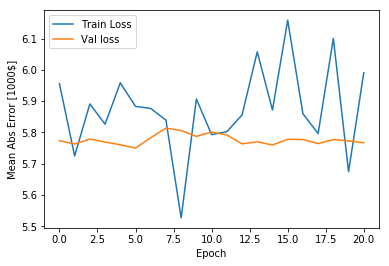

In [59]:
plot_history(history)